### Preview dataset and some examples with images

Dataset Information:
Total number of images: 2527

Number of images per category:
category
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64

First 5 rows of the dataset:
                                          image_path category
0  data/garbage classification/Garbage classifica...    paper
1  data/garbage classification/Garbage classifica...    paper
2  data/garbage classification/Garbage classifica...    paper
3  data/garbage classification/Garbage classifica...    paper
4  data/garbage classification/Garbage classifica...    paper


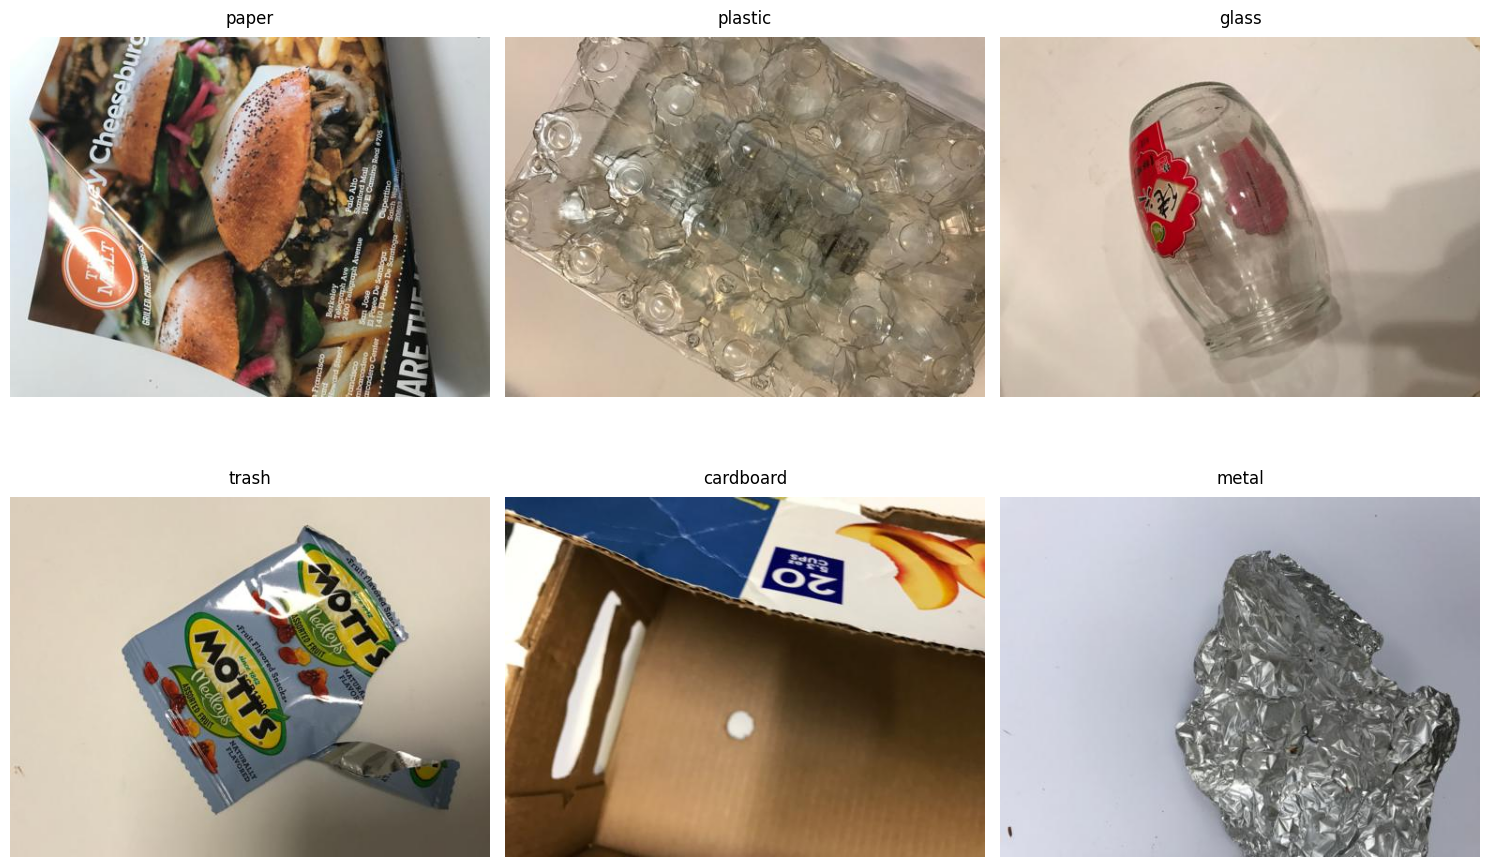


Image Statistics:

Image dimensions statistics:
        width  height
count  2527.0  2527.0
mean    512.0   384.0
std       0.0     0.0
min     512.0   384.0
25%     512.0   384.0
50%     512.0   384.0
75%     512.0   384.0
max     512.0   384.0


In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Set up matplotlib for better visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]

# Define the base path to the dataset
base_path = Path('data/garbage classification/Garbage classification')

# Create lists to store the data
image_paths = []
categories = []

# Walk through the directory and collect all image paths and their categories
for category in os.listdir(base_path):
    category_path = base_path / category
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            if image_file.endswith('.jpg'):
                image_paths.append(str(category_path / image_file))
                categories.append(category)

# Create the DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'category': categories
})

# Display basic information about the dataset
print("Dataset Information:")
print(f"Total number of images: {len(df)}")
print("\nNumber of images per category:")
print(df['category'].value_counts())

# Display the first few rows of the DataFrame
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Create a figure with subplots for each category
plt.figure(figsize=(15, 10))

# Get one example from each category
for idx, category in enumerate(df['category'].unique()):
    # Get the first image path for this category
    image_path = df[df['category'] == category]['image_path'].iloc[0]
    
    # Create subplot
    plt.subplot(2, 3, idx + 1)
    
    # Read and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(category, fontsize=12, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Display some statistics about image sizes
print("\nImage Statistics:")
image_sizes = []
for path in df['image_path']:
    img = Image.open(path)
    image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['width', 'height'])
print("\nImage dimensions statistics:")
print(sizes_df.describe())

*** Split the data into training and testing sets  + Resize***

Data split sizes:
Training set: 1768 images
Validation set: 379 images
Test set: 380 images

Processing images...
Image processing complete!


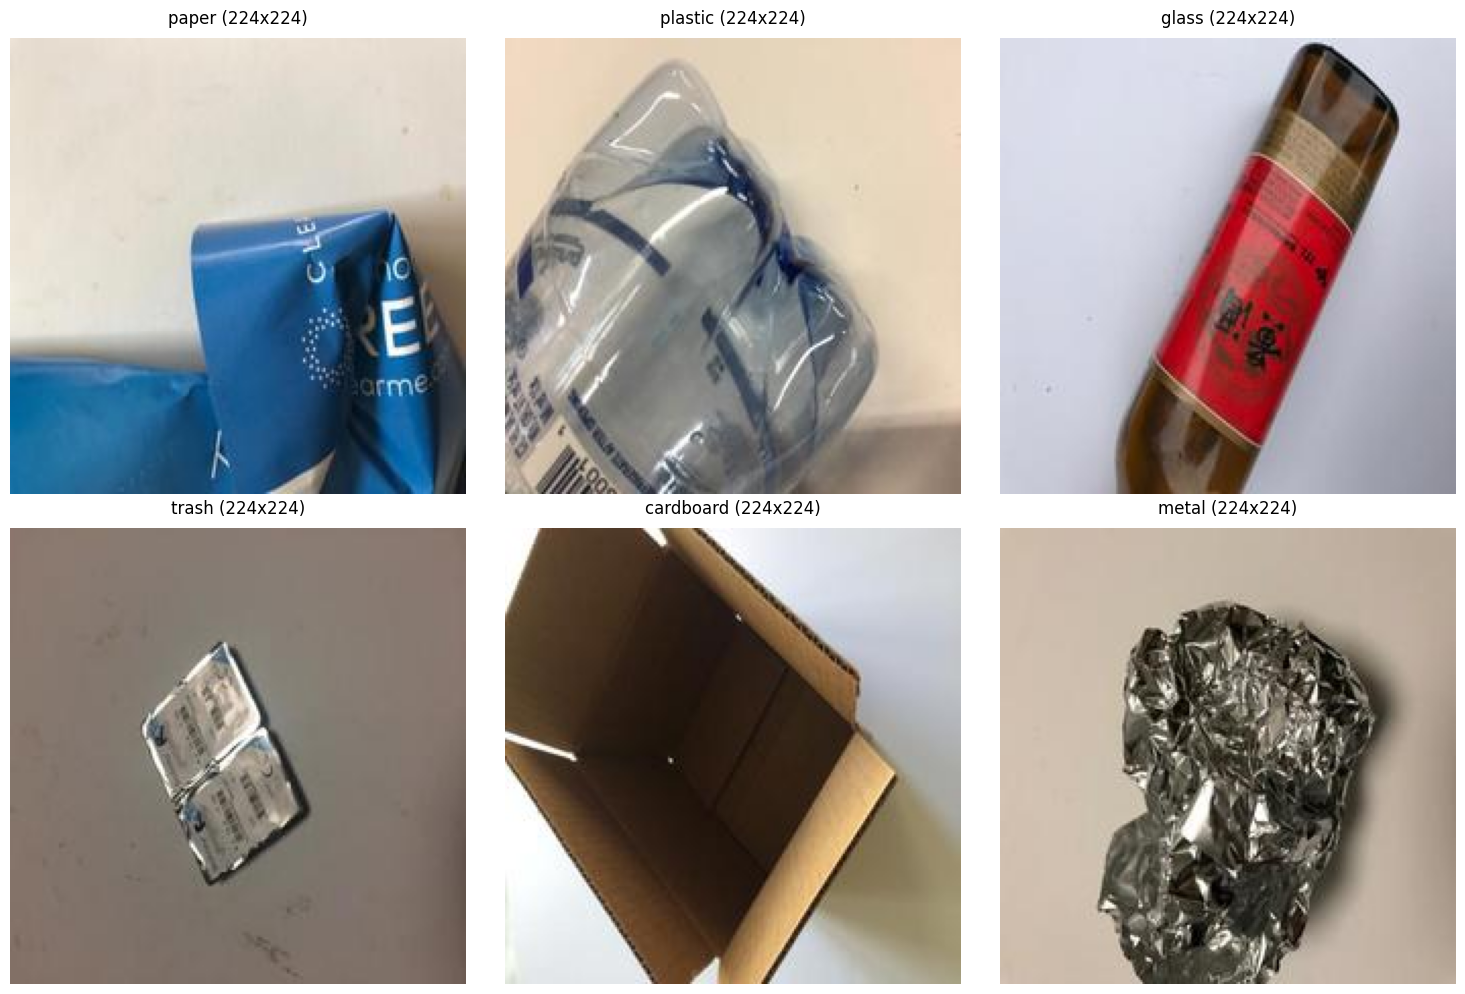

In [2]:
# Split data into train/validation/test sets
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (which will be split into val and test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])

# Second split: Split temp into validation and test (50% each of the remaining 30%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])

print("Data split sizes:")
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Function to resize and preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img = img.convert('RGB')  # Ensure image is in RGB format
    return img

# Create directories for processed images
processed_base = Path('data/processed')
for split in ['train', 'val', 'test']:
    (processed_base / split).mkdir(parents=True, exist_ok=True)
    for category in df['category'].unique():
        (processed_base / split / category).mkdir(parents=True, exist_ok=True)

# Process and save images for each split
def process_and_save_split(split_df, split_name):
    for idx, row in split_df.iterrows():
        # Get the image and category
        img = preprocess_image(row['image_path'])
        category = row['category']
        
        # Create new filename
        new_filename = f"{idx}_{Path(row['image_path']).name}"
        save_path = processed_base / split_name / category / new_filename
        
        # Save the processed image
        img.save(save_path)

# Process all splits
print("\nProcessing images...")
process_and_save_split(train_df, 'train')
process_and_save_split(val_df, 'val')
process_and_save_split(test_df, 'test')
print("Image processing complete!")

# Display sample of processed images
plt.figure(figsize=(15, 10))
for idx, category in enumerate(df['category'].unique()):
    # Get the first processed image path for this category
    processed_path = next((processed_base / 'train' / category).glob('*.jpg'))
    
    plt.subplot(2, 3, idx + 1)
    img = Image.open(processed_path)
    plt.imshow(img)
    plt.title(f"{category} (224x224)", fontsize=12, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Transfer Learning Setup
Choose a pre-trained model:

MobileNetV2 (fast, lightweight) or EfficientNetB0 (better accuracy).

Freeze base model:

Add custom layers:





In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

# MobileNetV2

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# freeze at custom layers

base_model.trainable = False

# add new layers to the basel model from MobileNetV2

""" model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 clases
])
 """
# Arquitectura mejorada
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  # Más neuronas para mejor capacidad
    layers.BatchNormalization(),          # Estabiliza el entrenamiento
    layers.Dropout(0.5),                 # Mayor dropout para evitar overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 categorías
])

2025-06-03 09:28:36.189463: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 09:28:36.197590: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 09:28:36.255154: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 09:28:36.310482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748939316.361741    7171 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748939316.37

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#### **3. Training Pipeline**  
**Data Augmentation**:  


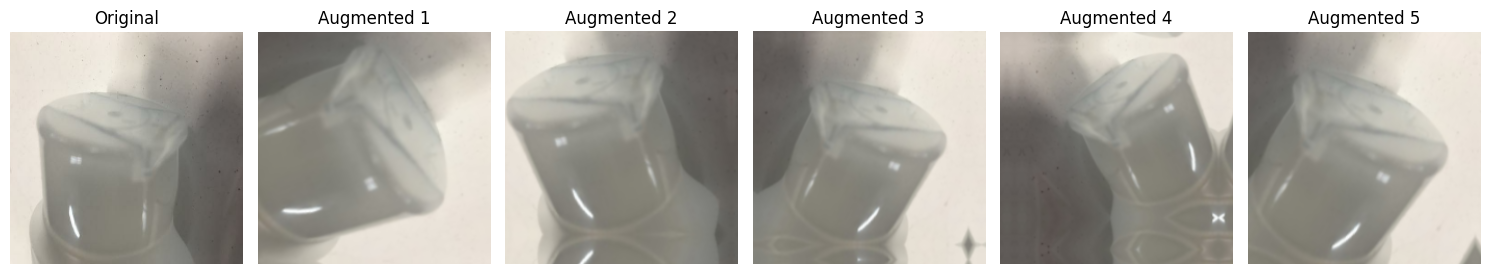

In [13]:
# Data Augmentation Setup
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
])

def load_and_preprocess_image(image_path, label, augment=True):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    if augment:
        img = tf.expand_dims(img, axis=0)
        img = data_augmentation(img, training=True)
        img = tf.squeeze(img, axis=0)
        # Apply random brightness and contrast using tf.image
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        img = tf.clip_by_value(img, 0.0, 1.0)  # Ensure valid range
    return img, label

def create_dataset(df, augment=True, batch_size=32):
    image_paths = df['image_path'].values
    labels = df['category'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_df, augment=True)
val_dataset = create_dataset(val_df, augment=False)
test_dataset = create_dataset(test_df, augment=False)

def visualize_augmentation(image_path, num_samples=5):
    plt.figure(figsize=(15, 3))
    # Original image
    plt.subplot(1, num_samples + 1, 1)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')
    # Augmented images
    for i in range(num_samples):
        plt.subplot(1, num_samples + 1, i + 2)
        aug_img = tf.expand_dims(img, axis=0)
        aug_img = data_augmentation(aug_img, training=True)
        aug_img = tf.squeeze(aug_img, axis=0)
        plt.imshow(aug_img)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage of visualization
sample_image_path = train_df['image_path'].iloc[0]
visualize_augmentation(sample_image_path)

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

*** Compile & Train***

In [ ]:
# Compile & Train

from tensorflow.keras import optimizers, callbacks

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if your labels are one-hot encoded
    metrics=['accuracy']
)

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### **4. Evaluation & Improvement**  
- **Plot training curves** (loss/accuracy) to check for overfitting.  





 

 **Test on unseen data**: Evaluate on `test_df`.  

#### **5. Deployment (Optional)**  
*** TBD ***

---

### **Key Considerations**  
- **Class Balance**: Ensure no class dominates (use `stratify` in train-test split).  
- **Image Size**: Standardize all images to the input size of your model.  
- **Augmentation**: Crucial for small datasets to prevent overfitting.  

---

### **Expected Results**  
With transfer learning + augmentation, aim for:  
- **Validation Accuracy**: 85%+  
- **Test Accuracy**: Within 5% of validation accuracy.